# Projeto Renan - Machine Learning II
***

## Importando bibliotecas

In [5]:
# Bibliotecas de manipualção e visualização de dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from scipy.io import arff

# Classes para pré-processamento
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Classes do modelo de aprendizado
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Funções de avaliação dos modelos
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, StratifiedKFold, GridSearchCV
from sklearn.metrics import (confusion_matrix,
                             ConfusionMatrixDisplay,
                             classification_report,
                             RocCurveDisplay,
                             roc_curve,
                             auc, accuracy_score, precision_score)


import warnings
warnings.filterwarnings('ignore')

## Análise do conjunto de dados

In [6]:

d = arff.loadarff("/content/sample_data/indian_pines.arff")
dataset = pd.DataFrame(d[0])


In [7]:
# Distribuição das classes por Features
target_col = 'Class'
print(dataset["Class"].value_counts())

b'Soybeans'    4050
b'Corn'        2502
b'Trees'       1294
b'Grass'        523
b'Hay'          489
b'Wheat'        212
b'Alfalfa'       54
b'Oats'          20
Name: Class, dtype: int64


##Pré-Processamento e Hiperparamentros

### Pré-Processamento dos dados

In [8]:
#Arrays do Banco de dados
X = dataset.loc[:,"0":"219"]
y = dataset.loc[:,["Class"]]

#Criando Dataset NORMALIZADO Z
s_dataset = dataset.copy(deep= True)
stdScaler = StandardScaler()
stdScaler.fit(X)
s_dataset.loc[:,"0":"219"] = stdScaler.fit_transform(X,y=True)

#Analisando médias e desvio padrão do dataset não normalizado e normalizado
print (s_dataset.mean().max() - s_dataset.mean().min())
print (s_dataset.std().max() - s_dataset.std().min())

2.3125275389567564e-14
4.440892098500626e-16


###Setup Inicial

In [9]:
#Refatorando varíaveis de saída do dataset padrão
dataset['Class'], classArray = pd.factorize(dataset['Class'])
print(classArray)

#Refatorando varíaveis de saída do dataset normalizado
s_dataset['Class'] = pd.factorize(s_dataset['Class'])[0]

#Verificando features
s_X = s_dataset.loc[:,"0":"219"]
s_y = s_dataset.loc[:,["Class"]]
print(s_dataset["Class"].value_counts())

#Gerando objeto kfold
kFoldObj = KFold(n_splits=5,shuffle=True,random_state=199)

Index([b'Alfalfa', b'Corn', b'Grass', b'Hay', b'Oats', b'Soybeans', b'Wheat',
       b'Trees'],
      dtype='object')
5    4050
1    2502
7    1294
2     523
3     489
6     212
0      54
4      20
Name: Class, dtype: int64


### Oversampling


In [10]:
#Oversampling o banco de dados normalizado
smt = SMOTE(random_state=20)
X_smt, y_smt = smt.fit_resample(s_X,s_y)
y_a = y_smt[y_smt.columns[0]]
print("Número de atributos (features): ", X_smt.drop([X_smt.columns[0]], axis = 1).shape[1])
print(X_smt.shape)
#retornando Labeling para teste
##y_smt["Class"] = classArray[y_smt]



Número de atributos (features):  219
(32400, 220)


### Feature Selection (Extração de Caracteristicas)

####PCA

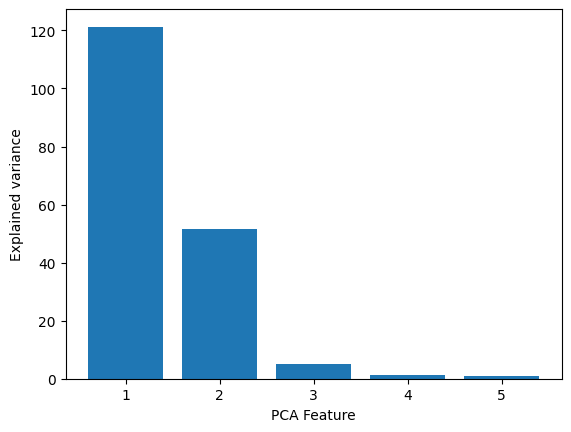

In [11]:
#PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_smt)

#Analisando os Vetores PCA
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )

plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.show()

####LDA

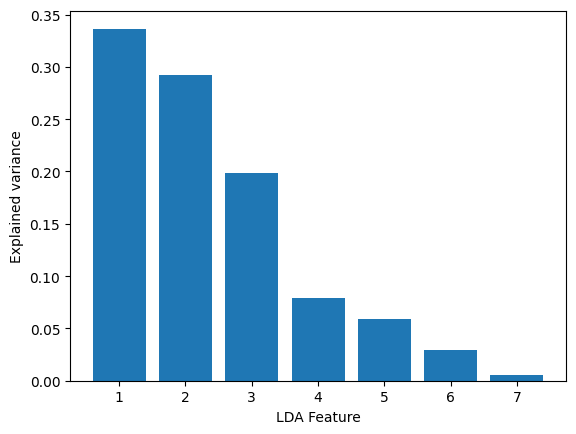

In [23]:
#LDA
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X_smt,y_smt)

plt.bar(
    range(1,len(lda.explained_variance_ratio_)+1),
    lda.explained_variance_ratio_
    )

plt.xlabel('LDA Feature')
plt.ylabel('Explained variance')
plt.show()

#### ANOVA

In [13]:
#ANOVA

###Hiperparâmetros e Funções

####Para *KNN*


In [14]:
#Definindo distância Customizada para KNN
def manhattan_custom_distance(x, y, weights=np.array([2, 1])):
    return (abs(x - y)*weights).sum()

#Arrays Hiperparametros
ks = [1]
distArray = ["manhattan"]

####Para *MLP*

In [15]:
#Arrays Hiperparamentros

n = [100]
learningRateInit = [0.0001]
learningRate= ['constant']

## Treinamento do modelo

###Treinamento **KNN**

####Treinamento com PCA

In [28]:
#KNN com PCA
model = KNeighborsClassifier()
parameters = {'n_neighbors': ks,
                      'metric':distArray}

grid = GridSearchCV(estimator = model,
                    param_grid = parameters,
                    scoring = 'precision_macro',
                    cv = 3)
def evaluate_model_with_kfold(kf):
    precision_list = []
    fold = 0
    for train, test in kf.split(X_smt, y_smt):

        y_train, y_test = y_smt.iloc[train], y_smt.iloc[test]

        X_pca_train = pca.fit_transform(X_smt.iloc[train])
        X_pca_test = pca.transform(X_smt.iloc[test])

        grid.fit(X_pca_train, y_train)

        y_pred = grid.predict(X_pca_test)

        print("\nMelhor parametro:", grid.best_params_)
        print(classification_report(y_test, grid.predict(X_pca_test)))
        print("Fold %d: %.3f" %(fold, precision_score(y_test, y_pred,average="macro")))

        precision_list.append(precision_score(y_test, y_pred,average="macro"))
        print("Media do modelo ", precision_list[fold].mean())

        fold += 1

    precision = np.array(precision_list)
    print("\nPrecisão média (desvio): %.3f +- (%.3f)" %(precision.mean(), precision.std()))

# chamada da função de Treino com KFOLD
evaluate_model_with_kfold(kFoldObj)


Melhor parametro: {'metric': 'manhattan', 'n_neighbors': 1}
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       823
           1       0.76      0.84      0.80       811
           2       0.97      0.99      0.98       814
           3       0.99      0.98      0.99       813
           4       1.00      1.00      1.00       809
           5       0.81      0.72      0.76       807
           6       1.00      1.00      1.00       809
           7       1.00      0.98      0.99       794

    accuracy                           0.94      6480
   macro avg       0.94      0.94      0.94      6480
weighted avg       0.94      0.94      0.94      6480

Fold 0: 0.939
Media do modelo  0.9388485299879346

Melhor parametro: {'metric': 'manhattan', 'n_neighbors': 1}
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       826
           1       0.75      0.83      0.79       806
           2  

####Treinamento com LDA

In [25]:
#KNN com LDA
model = KNeighborsClassifier()
parameters = {'n_neighbors': ks,
                      'metric':distArray}

grid = GridSearchCV(estimator = model,
                    param_grid = parameters,
                    scoring = 'precision_macro',
                    cv = 3)
def evaluate_model_with_kfold(kf):
    precision_list = []
    fold = 0
    for train, test in kf.split(X_smt, y_smt):

        y_train, y_test = y_smt.iloc[train], y_smt.iloc[test]

        X_lda_train = lda.fit_transform(X_smt.iloc[train],y_train)
        X_lda_test = lda.transform(X_smt.iloc[test])

        grid.fit(X_lda_train, y_train)

        y_pred = grid.predict(X_lda_test)

        print("\nMelhor parametro:", grid.best_params_)
        print(classification_report(y_test, grid.predict(X_lda_test)))
        print("Fold %d: %.3f" %(fold, precision_score(y_test, y_pred,average="macro")))

        precision_list.append(precision_score(y_test, y_pred,average="macro"))
        print("Media do modelo ", precision_list[fold].mean())

        fold += 1

    precision = np.array(precision_list)
    print("\nPrecisão média (desvio): %.3f +- (%.3f)" %(precision.mean(), precision.std()))

# chamada da função de Treino com KFOLD
evaluate_model_with_kfold(kFoldObj)


Melhor parametro: {'metric': 'manhattan', 'n_neighbors': 1}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       823
           1       0.80      0.87      0.83       811
           2       0.99      1.00      1.00       814
           3       1.00      1.00      1.00       813
           4       1.00      1.00      1.00       809
           5       0.85      0.77      0.81       807
           6       1.00      1.00      1.00       809
           7       1.00      1.00      1.00       794

    accuracy                           0.95      6480
   macro avg       0.96      0.95      0.95      6480
weighted avg       0.96      0.95      0.95      6480

Fold 0: 0.955
Media do modelo  0.9552970929295341

Melhor parametro: {'metric': 'manhattan', 'n_neighbors': 1}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       826
           1       0.82      0.87      0.84       806
           2  

####Treinamento com ANOVA

In [ ]:
#KNN com ANOVA
model = KNeighborsClassifier()
parameters = {'n_neighbors': ks,
                      'metric':distArray}

grid = GridSearchCV(estimator = model,
                    param_grid = parameters,
                    scoring = 'precision_macro',
                    cv = 3)
def evaluate_model_with_kfold(kf):
    precision_list = []
    fold = 0
    for train, test in kf.split(X_smt, y_smt):

        y_train, y_test = y_smt.iloc[train], y_smt.iloc[test]

        X_lda_train = lda.fit_transform(X_smt.iloc[train],y_train)
        X_lda_test = lda.transform(X_smt.iloc[test])

        grid.fit(X_lda_train, y_train)

        y_pred = grid.predict(X_lda_test)

        print("\nMelhor parametro:", grid.best_params_)
        print(classification_report(y_test, grid.predict(X_lda_test)))
        print("Fold %d: %.3f" %(fold, precision_score(y_test, y_pred,average="macro")))

        precision_list.append(precision_score(y_test, y_pred,average="macro"))
        print("Media do modelo ", precision_list[fold].mean())

        fold += 1

    precision = np.array(precision_list)
    print("\nPrecisão média (desvio): %.3f +- (%.3f)" %(precision.mean(), precision.std()))

# chamada da função de Treino com KFOLD
evaluate_model_with_kfold(kFoldObj)

###Treinamento **MLP**

####Treinamento com PCA

In [11]:
#MLP com PCA

model = MLPClassifier()
train_score = []
val_score = []

parameters = {'hidden_layer_sizes':n,
              'learning_rate': learningRate,
              'learning_rate_init': learningRateInit}

grid = GridSearchCV(estimator = model,
                    param_grid = parameters,
                    scoring = 'precision_macro',
                    cv = 2)

def evaluate_model_with_kfold(kf):
    precision_list = []
    fold = 0
    for train, test in kf.split(X_smt, y_smt):

        X_train, X_test = X_smt.iloc[train], X_smt.iloc[test]
        y_train, y_test = y_smt.iloc[train], y_smt.iloc[test]

        grid.fit(X_train, y_train)

        y_pred = grid.predict(X_test)

        print("\nMelhor parametro:", grid.best_params_)
        print(classification_report(y_test, grid.predict(X_test)))
        print("Fold %d: %.3f" %(fold, precision_score(y_test, y_pred,average="macro")))

        precision_list.append(precision_score(y_test, y_pred,average="macro"))
        print("Media do modelo ", precision_list[fold].mean())

        fold += 1

    precision = np.array(precision_list)
    print("\nPrecisão média (desvio): %.3f +- (%.3f)" %(precision.mean(), precision.std()))

# chamada da função de Treino com KFOLD
evaluate_model_with_kfold(kFoldObj)




Melhor parametro: {'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'learning_rate_init': 0.0001}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       823
           1       0.93      0.94      0.93       811
           2       0.99      1.00      0.99       814
           3       1.00      1.00      1.00       813
           4       1.00      1.00      1.00       809
           5       0.94      0.92      0.93       807
           6       1.00      1.00      1.00       809
           7       1.00      0.99      1.00       794

    accuracy                           0.98      6480
   macro avg       0.98      0.98      0.98      6480
weighted avg       0.98      0.98      0.98      6480

Fold 0: 0.982
Media do modelo  0.9817310072862537

Melhor parametro: {'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'learning_rate_init': 0.0001}
              precision    recall  f1-score   support

           0       1.00      1.0

####Trainamento com LDA

In [ ]:
#MLP com LDA

##Aplicando modelos para todo dataset

In [ ]:
#Aplicando modelo Fold 9, como exeplo, para todo dataset
print(classification_report(y, grid.predict(X)))


              precision    recall  f1-score   support

           0       0.30      0.46      0.36        54
           1       0.64      0.14      0.23      2502
           2       0.64      0.65      0.65       523
           3       0.89      0.86      0.87       489
           4       0.17      0.05      0.08        20
           5       0.64      0.95      0.76      4050
           6       0.94      0.80      0.87       212
           7       0.95      0.95      0.95      1294

    accuracy                           0.70      9144
   macro avg       0.64      0.61      0.60      9144
weighted avg       0.70      0.70      0.64      9144

